# This tutorial will guide you through applying the cloud identification method in a small region of the sky. 
## The method is described in Panopoulou & Lenz (2020): https://ui.adsabs.harvard.edu/abs/2020arXiv200400647P/abstract

In [34]:
import numpy as np
import healpy as hp
import tables
import matplotlib.pyplot as plt

import sys
sys.path.append('cloudcount/')
import main
import preprocess_functions
import postprocess_functions

import os
import time
import pickle
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [35]:
reload(postprocess_functions)

<module 'postprocess_functions' from 'postprocess_functions.py'>

In [2]:
# HI4PI
CRPIX3_hi4pi= 466
CDELT3_hi4pi = 1288.21496


def chan2velo(channel, CRPIX3 = CRPIX3_hi4pi, CDELT3 = CDELT3_hi4pi):
    """
    Convert Channel to LSR velocity in m/s
    """
    return (channel - CRPIX3) * CDELT3


# Parameters

In [3]:
nside_low = 128
nside_high  = 1024


savedir = 'my_region/'

In [4]:
if not os.path.exists(savedir):
    os.mkdir(savedir)

# Select superpixels of the region you are interested in

In [4]:
radius = 3. # degrees

l = 104.
b = 22.

v = hp.ang2vec(l, b, lonlat=True)
area = hp.query_disc(nside_low, v, np.radians(radius),nest=True)

mask_low = np.zeros(hp.nside2npix(nside_low))
mask_low[area] = 1

## Create list of pixels to be input to cloud finding code

In [5]:
NSIDE_LOW_PIXELS_NEST = np.where(mask_low == 1)[0]

NSIDE_LOW_PIXELS_NEST.shape

(133,)

# Step 1 of pre-processing: Collect Gaussian components of each superpixel of the region

In [7]:
# File that contains Gaussian decomposition
gaussdecompfile = '/media/gin/Avocado/Datasets/gaussdec_v4.h5'
savename = 'collected_N%d.pkl'%nside_low
preprocess_functions.collect(nside_low, nside_high, NSIDE_LOW_PIXELS_NEST, gaussdecompfile, savedir, savename)

'Pixel number 132 of 132'

# Step 2 of pre-processing: Remove Gaussians associated with noise boxes (stray radiation patterns, primarily in the EBHIS footprint, see appendix A of paper).

In [21]:
# Filename that stores Gaussian components per pixel
gcfilename = savedir+'/collected_N%d.pkl'%nside_low
# File that contains coordinates of noise squares
noisefilename = 'Noise_squares_by_eye.txt'

# Will create a mask for each superpixel and append it in the gcfilename
preprocess_functions.clean_from_noise_squares(gcfilename, noisefilename, savedir, \
                                              nside_low, nside_high, CRPIX3_hi4pi, CDELT3_hi4pi)

'Pixel number 132 of 132'

# Run cloud identification

In [26]:
startt = time.time()

bandwidth  = 3

savename = 'collected_N%d.pkl'%nside_low


datafile = savedir+'/'+savename

SFILENAME = 'clouds_per_sqdeg_btw_%d_nside%d.pickle'%(bandwidth,nside_low)#'clouds_per_sqdeg_newminmax_kernel2.pickle'

RMScut = 0.039 # (K) Gaussians with amplitude less than the noise rms level will be discarded



main.run_cloud_identification(SFILENAME, savedir, datafile, RMSCUT = RMScut, SIGMACUT = 15,\
                         BANDWIDTH =bandwidth, RETURN_ARRS=False, REMOVE_NOISE = True)

endt = time.time()

print 'Took seconds:', endt-startt

'Pixel number 132 of 132'Took seconds: 7.3472840786


# Load the cloud data

In [27]:
fop = open(savedir+SFILENAME)
clouds_per_sq_deg = pickle.load(fop)

# Post-process the output of the method to calculate cloud properties and generate maps

In [38]:
# Not all 'clouds' should be used: make a velocity cut to remove HVCs (good for north sky only), make other quality cuts
Ngauscut = 20 # discard any cloud that has less than this number of Gaussian components

cmin = 411 # channel number below which clouds are probably HVC (north gal cap only) < -70 km/s
cmax = 520 # +70

NHcut = 0
keeplow = False

compute_centroid = True # The first time that you load the data, set this to true. It will compute cloud centroids
modify_cloudlist = True

kwargs = {'nside_low':nside_low,'cmin':cmin,'cmax':cmax,'Ngauscut':Ngauscut,\
          'NHcut':NHcut,'keeplow':keeplow,'compute_centroid':compute_centroid, 
          'modify_cloudlist':modify_cloudlist}


Nclouds_map_lowres_noHVC, Nclouds_map_highres_noHVC, NH_map_lowres_noHVC, NH_map_highres_noHVC,\
    superpixel_array_noHVC, cloud_NHs_noHVC, cloud_mean_vels_noHVC, cloud_mean_sigmas_noHVC, \
    Nclouds_noHVC, Ngaus_noHVC, Npix_noHVC, Ngaus_per_pixel_noHVC, cloud_skewness_noHVC, \
    Neff_map_lowres_noHVC, skewnessmeanspec_noHVC, Nmaxima_noHVC, clouds_per_sq_deg_full = \
            postprocess_functions.make_arrays_vcut(clouds_per_sq_deg, **kwargs)

Total of 133


## Save the new cloud dictionary (it contains cloud centroids, second moments, nmaxima, asymmetry of spectrum)

In [39]:
SFILENAME = 'clouds_per_sqdeg_btw_4_full.pickle'
pickle.dump(clouds_per_sq_deg_full, open(savedir+SFILENAME, 'w'))

In [40]:
clouds_per_sq_deg_full =0

# From now on, load in the '_full' version of the cloud data

In [41]:
fop = open(savedir+SFILENAME)
clouds_per_sq_deg = pickle.load(fop)

## make maps & datasets of cloud properties

In [44]:
# Not all 'clouds' should be used: make a velocity cut to remove HVCs (good for north sky only), make other quality cuts
Ngauscut = 20 # discard any cloud that has less than this number of Gaussian components

cmin = 411 # channel number below which clouds are probably HVC (north gal cap only) < -70 km/s
cmax = 520 # +70

NHcut = 0
keeplow = False

compute_centroid = False # The first time that you load the data, set this to true. It will compute cloud centroids
modify_cloudlist = False

kwargs = {'nside_low':nside_low,'cmin':cmin,'cmax':cmax,'Ngauscut':Ngauscut,\
          'NHcut':NHcut,'keeplow':keeplow,'compute_centroid':compute_centroid, 
          'modify_cloudlist':modify_cloudlist}


Nclouds_map_lowres_noHVC, Nclouds_map_highres_noHVC, NH_map_lowres_noHVC, NH_map_highres_noHVC,\
    superpixel_array_noHVC, cloud_NHs_noHVC, cloud_mean_vels_noHVC, cloud_mean_sigmas_noHVC, \
    Nclouds_noHVC, Ngaus_noHVC, Npix_noHVC, Ngaus_per_pixel_noHVC, cloud_skewness_noHVC, \
    Neff_map_lowres_noHVC, skewnessmeanspec_noHVC, Nmaxima_noHVC = \
            postprocess_functions.make_arrays_vcut(clouds_per_sq_deg, **kwargs)

Total of 133


# Show map of Nclouds

81.2475645381 98.7524354619 -8.75243546187 8.75243546187
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 10 deg 0.00'.


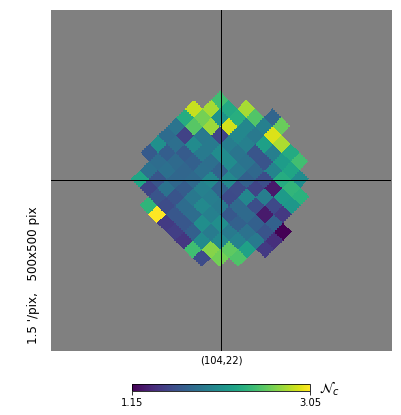

In [48]:
hp.gnomview(Neff_map_lowres_noHVC, rot = [l,b,0], reso = 1.5, xsize = 500, nest = True, cmap = 'viridis', \
            fig = 1, title='', unit = '$\mathcal{N}_c$')
hp.graticule(dmer = 10, dpar = 10)

In [50]:
import astropy
astropy.__version__

u'2.0.9'

In [51]:
tables.__version__

'3.4.4'